# Image Study

## The theory

We will investigate three types of networks in thie notebook to evaluate their performances and then decide which is the best one. First, a basic **CNN** created **from scratch**. Then, a much more complex **pretrained model from Huggingface**, which will be modified as its last layer is a classification one and our problem is regression based. Finally, we will investigate about **3D-CNNs**, a special variant of tghe standard CNNs that not only analyzes images with the usual 2 diensions: Height and width, but also with **time**.

For the inputs, we will extract 8 frames from each tiktok and use them as a valid representation of what the tiktok is. This means that, no matter what the batch size of our networks are, the input of the networks will be 8 images of 3 channels per tiktok.

In [1]:
from image_utils import remove_mp4_extensions, extract_frames, rename_frames_ids
import numpy as np
import pandas as pd
import os
import re
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from pathlib import Path
import sys
import PIL

In [2]:
root_dir = Path.cwd().resolve().parent.parent
sys.path.append(str(root_dir))
from config.variables import text_path, json_file, csv_file, textcsv_file

## Frame extraction

In [3]:
extract_frames(8)
# remove_mp4_extensions()

Saved: ../../data/inputs/frames\6875317312082201857_frame_0.png | Frame ID: 0
Saved: ../../data/inputs/frames\6875317312082201857_frame_1.png | Frame ID: 30
Saved: ../../data/inputs/frames\6875317312082201857_frame_2.png | Frame ID: 61
Saved: ../../data/inputs/frames\6875317312082201857_frame_3.png | Frame ID: 91
Saved: ../../data/inputs/frames\6875317312082201857_frame_4.png | Frame ID: 122
Saved: ../../data/inputs/frames\6875317312082201857_frame_5.png | Frame ID: 152
Saved: ../../data/inputs/frames\6875317312082201857_frame_6.png | Frame ID: 183
Saved: ../../data/inputs/frames\6875317312082201857_frame_7.png | Frame ID: 213
Saved: ../../data/inputs/frames\6875323773755657474_frame_0.png | Frame ID: 0
Saved: ../../data/inputs/frames\6875323773755657474_frame_1.png | Frame ID: 67
Saved: ../../data/inputs/frames\6875323773755657474_frame_2.png | Frame ID: 134
Saved: ../../data/inputs/frames\6875323773755657474_frame_3.png | Frame ID: 201
Saved: ../../data/inputs/frames\6875323773755657

In [3]:
# rename_frames_ids()

Renombrado: 6875317312082201857_frame_0.png a 6875317312082201857_frame_0.png
Renombrado: 6875317312082201857_frame_24.png a 6875317312082201857_frame_1.png
Renombrado: 6875317312082201857_frame_47.png a 6875317312082201857_frame_2.png
Renombrado: 6875317312082201857_frame_71.png a 6875317312082201857_frame_3.png
Renombrado: 6875317312082201857_frame_95.png a 6875317312082201857_frame_4.png
Renombrado: 6875317312082201857_frame_118.png a 6875317312082201857_frame_5.png
Renombrado: 6875317312082201857_frame_142.png a 6875317312082201857_frame_6.png
Renombrado: 6875317312082201857_frame_166.png a 6875317312082201857_frame_7.png
Renombrado: 6875317312082201857_frame_189.png a 6875317312082201857_frame_8.png
Renombrado: 6875317312082201857_frame_213.png a 6875317312082201857_frame_9.png
Renombrado: 6875323773755657474_frame_0.png a 6875323773755657474_frame_0.png
Renombrado: 6875323773755657474_frame_52.png a 6875323773755657474_frame_1.png
Renombrado: 6875323773755657474_frame_104.png a 6

## Data loading

We'll declare a function to load one sample from the virality Dataframe for every 8 pictures from the frames folder, which is equivalent to one tiktok

In [4]:
from tensorflow.keras.preprocessing import image

def load_images(num_frames=8, img_height=224, img_width=224):
    dir = os.path.join(root_dir, 'data', 'inputs', 'frames')
    csv_path = os.path.join(root_dir, csv_file)
    df = pd.read_csv(csv_path, dtype={'id': str})
    X = []
    y = []

    # Iterar sobre cada fila del DataFrame
    for idx, row in df.iterrows():
        id_video = row['id']
        print(id_video)
        frames = []
        
        for j in range(num_frames):
            img_path = os.path.join(dir, f"{id_video}_frame_{j}.png")
            if os.path.exists(img_path):
                img = image.load_img(img_path, target_size=(img_height, img_width))
                img_array = image.img_to_array(img)
                frames.append(img_array)

        if len(frames) == num_frames:
            X.append(frames)
            y.append(row['norm_virality'])

    X = np.array(X) / 255.0
    y = np.array(y)

    return X, y

In [5]:
X, y = load_images(num_frames=8)


6907228749016714497
6875468410612993286
6898699405898059010
6902819837345533186
6905635666588192002
6895497835681287426
6895303013867539713
6884590643327290625
6906514963569888513
6894206452450217217
6902751117805899009
6886417103046380801
6883211681988627714
6892769736589888770
6906571896683285761
6907334602017344774
6883094233935252737
6906818204966915330
6876318382703070465
6900948690186407170
6875323773755657474
6884935459110178049
6892805816492084481
6886765050355289346
6875370613523909890
6890189236130073857
6901321371113032962
6893611785295793410
6904536120755768578
6888873392234056962
6879952519586450690
6884933059758755073
6895846066961337601
6884933447480003842
6883604590525156609
6886215675350666497
6899411430660001026
6898613799402753281
6885861410329332998
6879772200065436929
6893119957534510338
6881624031561354498
6896541657471241474
6884688821976354049
6906870391466216709
6901020148426099969
6898035916682710274
6901681280128208130
6887645369895898369
6905029441760578818


In [22]:
X.shape

(1000, 3, 16, 112, 112)

It is proved here that our imput has the shape of 8 images, 224x224 pixels, and 3 color channels

In [7]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.20, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.50, random_state=42)
print("Train set:", len(X_train))
print("Validation set:", len(X_valid))
print("Test set:", len(X_test))

Train set: 800
Validation set: 100
Test set: 100


Our 3 datasets are ready

## CNN

In [19]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(8, 224, 224, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(GlobalAveragePooling2D()),  # Reduce cada frame a un vector
    TimeDistributed(Flatten()),  # Asegúrate de que cada salida sea un vector plano
    Flatten(),  
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
X.shape

(1000, 3, 16, 112, 112)

In [20]:
history = model.fit(X_train, y_train, epochs=15, batch_size=16, validation_data=(X_valid, y_valid))

Epoch 1/15


ValueError: Exception encountered when calling TimeDistributed.call().

[1min user code:

    File "c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 244, in _conv_xla  *
        return _conv()
    File "c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 231, in _conv  **
        return tf.nn.convolution(

    ValueError: Depth of input (112) is not a multiple of input depth of filter (3) for '{{node convolution}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](convolution/sequential_1/time_distributed_1/strided_slice, convolution/ReadVariableOp)' with input shapes: [16,16,112,112], [3,3,3,32].
[0m

Arguments received by TimeDistributed.call():
  • inputs=tf.Tensor(shape=(16, 3, 16, 112, 112), dtype=float32)
  • training=True
  • mask=None

The results from the CNN are no too bad, but it is necessary to have into consideration that a 0.01 loss on validation, although looks good, it is the loss on the **norm_virality** value, so it has to be put into perspective that the values there can only go in between 0 and 1.

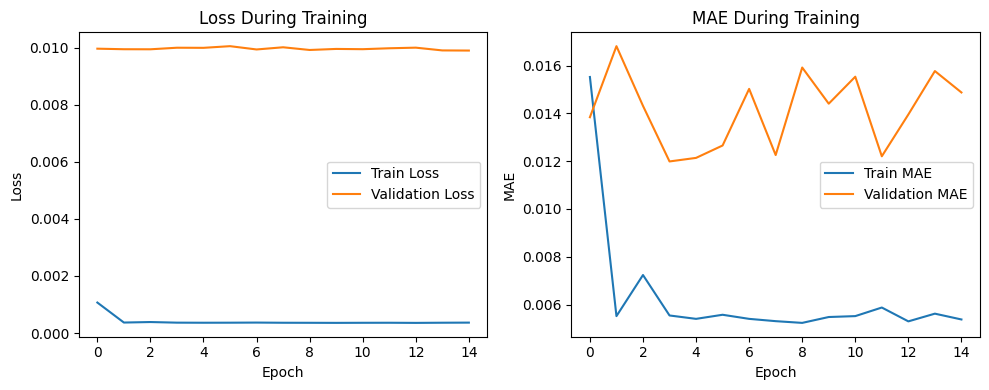

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
model.save_weights('8framesCNN.weights.h5')

In [13]:
#load weights
model.load_weights('8framesCNN.weights.h5')

In [14]:
train_mse, train_mae = model.evaluate(X_train, y_train, verbose=0)

# Evaluación en el conjunto de validación
valid_mse, valid_mae = model.evaluate(X_valid, y_valid, verbose=0)

In [15]:
train_rmse = np.sqrt(train_mse)
valid_rmse = np.sqrt(valid_mse)

In [16]:
print("Training Metrics:")
print("RMSE:", train_rmse)
print("MSE:", train_mse)
print("MAE:", train_mae)

print("\nValidation Metrics:")
print("RMSE:", valid_rmse)
print("MSE:", valid_mse)
print("MAE:", valid_mae)

Training Metrics:
RMSE: 0.019235054068572656
MSE: 0.0003699873050209135
MAE: 0.003626070683822036

Validation Metrics:
RMSE: 0.10009287380796127
MSE: 0.01001858338713646
MAE: 0.011656389571726322


## PRETRAINED TRANSFORMER

For a pretrained model, we take this one from google and change its last layer to make it a regression model and it is also necessary to alter the input phase to enable batches of 8 images (our tiktok represntation in 8 frames) per one virality sample.

In [7]:
import torch
from transformers import ViTModel, ViTConfig


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Cargar la configuración del modelo ViT preentrenado
config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Indicamos que no cargue la cabeza de clasificación
config.num_labels = 1

# Cargar el modelo ViT
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k', config=config)

c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from torch import nn


class ViTForMultiImageRegression(nn.Module):
    def __init__(self, vit_model, num_images=8):
        super(ViTForMultiImageRegression, self).__init__()
        self.num_images = num_images
        self.vit = vit_model  # El modelo base ViT
        self.regressor = nn.Linear(config.hidden_size * num_images, 1)  # Adaptamos la entrada de la capa lineal

    def forward(self, pixel_values):
        batch_size = pixel_values.shape[0]
        combined_output = []

        # Procesar cada imagen individualmente
        for i in range(self.num_images):
            output = self.vit(pixel_values=pixel_values[:, i])
            cls_token = output.last_hidden_state[:, 0]
            combined_output.append(cls_token)

        # Concatenar las representaciones de todas las imágenes
        combined_output = torch.cat(combined_output, dim=1)
        
        return self.regressor(combined_output)
    
regression_model = ViTForMultiImageRegression(model).to(device)


In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy array): Arreglo de imágenes con dimensiones [n_muestras, n_imágenes, H, W, C].
            labels (numpy array): Arreglo de etiquetas.
            transform (callable, optional): Transformaciones opcionales para aplicar a las imágenes.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_set = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            # Aplica transformaciones a cada imagen del conjunto
            transformed_images = [self.transform(image) for image in image_set]
            # Stack the images along a new dimension
            image_set = torch.stack(transformed_images)

        return {'image': image_set, 'label': torch.tensor(label, dtype=torch.float)}

# Definir transformaciones (normalización, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Asegúrate de que las dimensiones coincidan con las expectativas del modelo
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
# Crear datasets
train_dataset = ImageDataset(X_train, y_train, transform=transform)
valid_dataset = ImageDataset(X_valid, y_valid, transform=transform)
test_dataset = ImageDataset(X_test, y_test, transform=transform)

In [12]:
batch_size = 4  # Puedes ajustar esto según la capacidad de tu GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
from tqdm import tqdm


def train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric):
    model.train()
    total_loss = 0
    mse_metric.reset()
    rmse_metric.reset()
    mae_metric.reset()

    for batch in tqdm(train_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(batch['image'].to(device))
        outputs = torch.squeeze(outputs)
        targets = batch['label'].to(device)
        loss = nn.functional.mse_loss(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        mse_metric(outputs, targets)
        rmse_metric(outputs, targets)
        mae_metric(outputs, targets)

    mean_loss = total_loss / len(train_loader)
    mse = mse_metric.compute()
    rmse = rmse_metric.compute()
    mae = mae_metric.compute()
    return mean_loss, mse.item(), rmse.item(), mae.item()


def validate(model, loader, device, mse_metric, rmse_metric, mae_metric):
    model.eval()  # Pone el modelo en modo evaluación
    total_loss = 0
    mse_metric.reset()
    rmse_metric.reset()
    mae_metric.reset()

    # Asegurarte de que la métrica se ejecute en el dispositivo adecuado
    mse_metric.to(device)
    rmse_metric.to(device)
    mae_metric.to(device)

    with torch.no_grad():  # Instruye a PyTorch que no gestione gradientes durante la validación
        for batch in tqdm(loader, desc="Validation", leave=False):
            inputs = batch['image'].to(device)  # Envía las entradas a la GPU
            targets = batch['label'].to(device)  # Envía las etiquetas a la GPU
            outputs = model(inputs)
            outputs = torch.squeeze(outputs)  # Ajustar las dimensiones si es necesario
            
            loss = nn.functional.mse_loss(outputs, targets)
            total_loss += loss.item()
            
            mse_metric(outputs, targets)
            rmse_metric(outputs, targets)
            mae_metric(outputs, targets)

    mean_loss = total_loss / len(loader)
    mse = mse_metric.compute()
    rmse = rmse_metric.compute()
    mae = mae_metric.compute()
    return mean_loss, mse.item(), rmse.item(), mae.item()


In [14]:
from torch.optim import Adam

# Entrenamiento y validación en ciclos
optimizer = Adam(regression_model.parameters(), lr=1e-5)
num_epochs = 15

In [15]:
import torchmetrics

# Métricas
mse_metric = torchmetrics.MeanSquaredError().to(device)
rmse_metric = torchmetrics.MeanSquaredError(squared=False).to(device)
mae_metric = torchmetrics.MeanAbsoluteError().to(device)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Entrenamiento con cálculo de métricas
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(regression_model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)

    # Validación
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(regression_model, valid_loader, device, mse_metric, rmse_metric, mae_metric)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Imprimir resultados para la época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")

# Opcionalmente, guardar los datos para la visualización
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

Epoch 1/15


Epoch 1, Train Loss: 0.0077, Train MSE: 0.0077, Train RMSE: 0.0877, Train MAE: 0.0688
Validation Loss: 0.0167, Validation MSE: 0.0167, Validation RMSE: 0.1294, Validation MAE: 0.0653
Epoch 2/15


Epoch 2, Train Loss: 0.0017, Train MSE: 0.0017, Train RMSE: 0.0410, Train MAE: 0.0299
Validation Loss: 0.0144, Validation MSE: 0.0144, Validation RMSE: 0.1201, Validation MAE: 0.0542
Epoch 3/15


Epoch 3, Train Loss: 0.0008, Train MSE: 0.0008, Train RMSE: 0.0284, Train MAE: 0.0188
Validation Loss: 0.0143, Validation MSE: 0.0143, Validation RMSE: 0.1195, Validation MAE: 0.0517
Epoch 4/15


Epoch 4, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0218, Train MAE: 0.0133
Validation Loss: 0.0136, Validation MSE: 0.0136, Validation RMSE: 0.1168, Validation MAE: 0.0495
Epoch 5/15


Epoch 5, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0195, Train MAE: 0.0108
Validation Loss: 0.0138, Validation MSE: 0.0138, Validation RMSE: 0.1176, Validation MAE: 0.0517
Epoch 6/15


Epoch 6, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0212, Train MAE: 0.0114
Validation Loss: 0.0130, Validation MSE: 0.0130, Validation RMSE: 0.1139, Validation MAE: 0.0461
Epoch 7/15


Epoch 7, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0223, Train MAE: 0.0118
Validation Loss: 0.0131, Validation MSE: 0.0131, Validation RMSE: 0.1145, Validation MAE: 0.0443
Epoch 8/15


Epoch 8, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0215, Train MAE: 0.0123
Validation Loss: 0.0125, Validation MSE: 0.0125, Validation RMSE: 0.1116, Validation MAE: 0.0417
Epoch 9/15


Epoch 9, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0178, Train MAE: 0.0108
Validation Loss: 0.0124, Validation MSE: 0.0124, Validation RMSE: 0.1112, Validation MAE: 0.0428
Epoch 10/15


Epoch 10, Train Loss: 0.0002, Train MSE: 0.0002, Train RMSE: 0.0145, Train MAE: 0.0094
Validation Loss: 0.0122, Validation MSE: 0.0122, Validation RMSE: 0.1103, Validation MAE: 0.0411
Epoch 11/15


Epoch 11, Train Loss: 0.0002, Train MSE: 0.0002, Train RMSE: 0.0125, Train MAE: 0.0081
Validation Loss: 0.0120, Validation MSE: 0.0120, Validation RMSE: 0.1094, Validation MAE: 0.0398
Epoch 12/15


Epoch 12, Train Loss: 0.0001, Train MSE: 0.0001, Train RMSE: 0.0113, Train MAE: 0.0073
Validation Loss: 0.0119, Validation MSE: 0.0119, Validation RMSE: 0.1089, Validation MAE: 0.0378
Epoch 13/15


Epoch 13, Train Loss: 0.0001, Train MSE: 0.0001, Train RMSE: 0.0108, Train MAE: 0.0068
Validation Loss: 0.0119, Validation MSE: 0.0119, Validation RMSE: 0.1092, Validation MAE: 0.0378
Epoch 14/15


Epoch 14, Train Loss: 0.0001, Train MSE: 0.0001, Train RMSE: 0.0118, Train MAE: 0.0078
Validation Loss: 0.0117, Validation MSE: 0.0117, Validation RMSE: 0.1082, Validation MAE: 0.0369
Epoch 15/15


Epoch 15, Train Loss: 0.0002, Train MSE: 0.0002, Train RMSE: 0.0133, Train MAE: 0.0086
Validation Loss: 0.0115, Validation MSE: 0.0115, Validation RMSE: 0.1071, Validation MAE: 0.0354


### Results without unfreezing layers

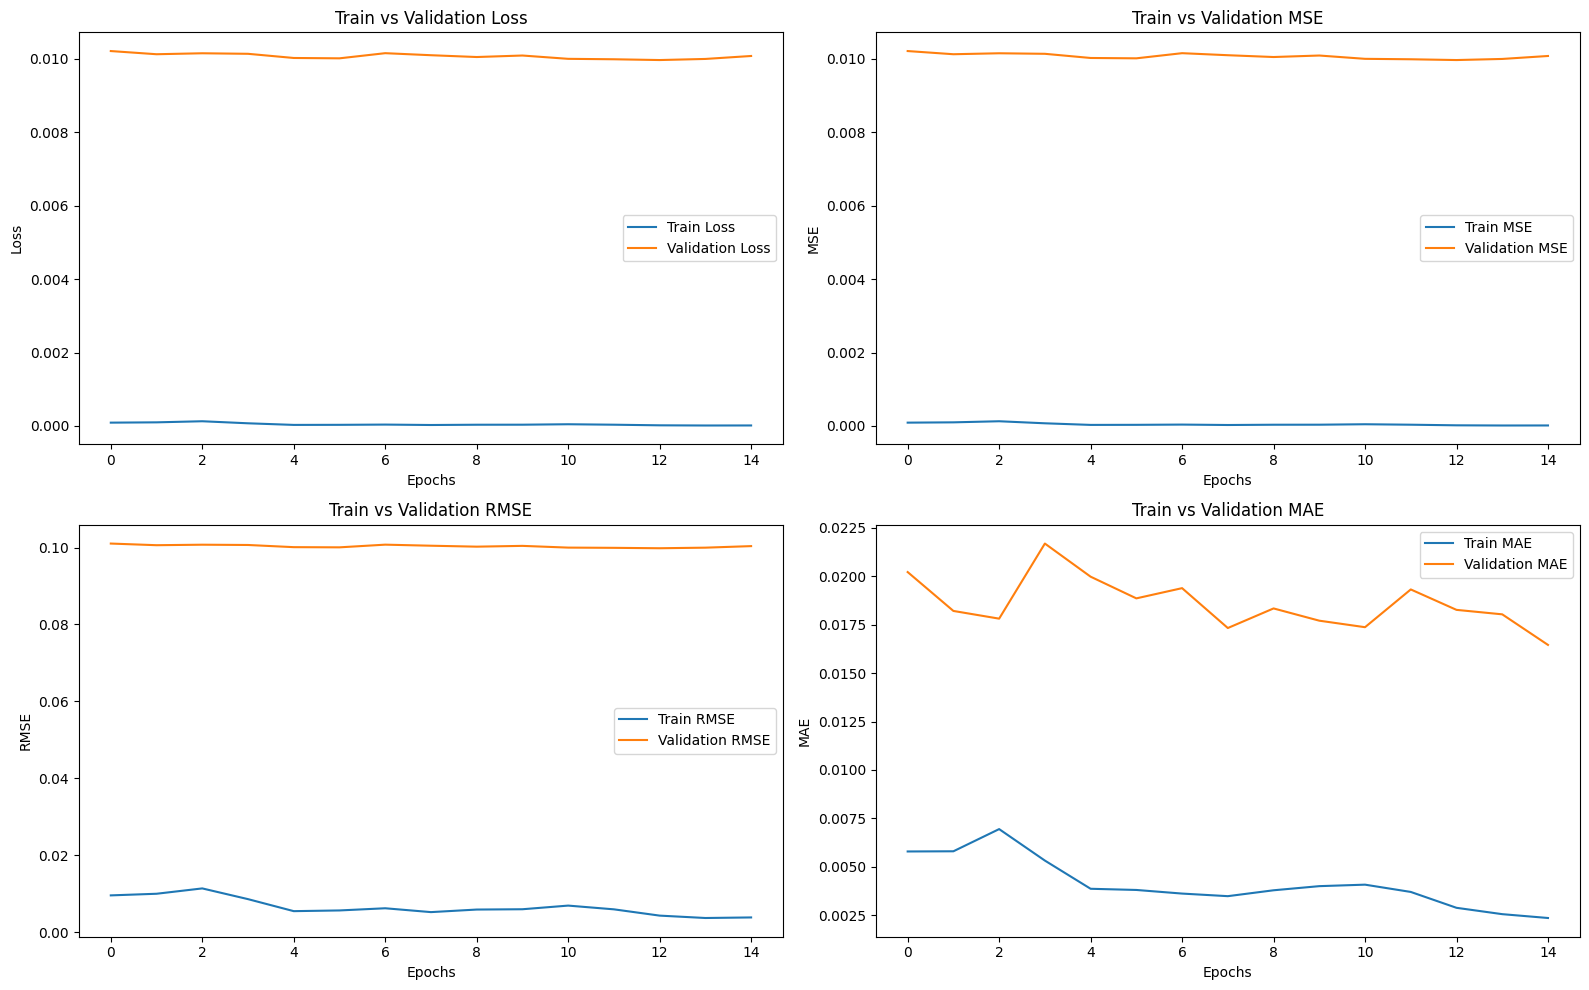

In [47]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

The results from the pretrained model are quite disappointing because they seem to be very similar to the ones obtasined from the standard CNN, with a notable overfitting as the vlaidation loss does not go down under 0.01

### Results unfreezing 4 layers

In [ ]:
print(regression_model)

ViTForMultiImageRegression(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [ ]:
num_layers_to_unfreeze = 4  # Ajusta esto según tus necesidades

# Iterar sobre los parámetros y hacerlos entrenables según la condición
for name, param in regression_model.named_parameters():
    # Esto activará el entrenamiento para las últimas N capas
    if 'encoder.layer' in name:
        layer_index = int(name.split('.')[3])  # Extraer el índice de la capa
        if layer_index >= 12 - num_layers_to_unfreeze:
            param.requires_grad = True
    # Asegúrate de que la capa de regresión también es entrenable
    if 'regressor' in name:
        param.requires_grad = True

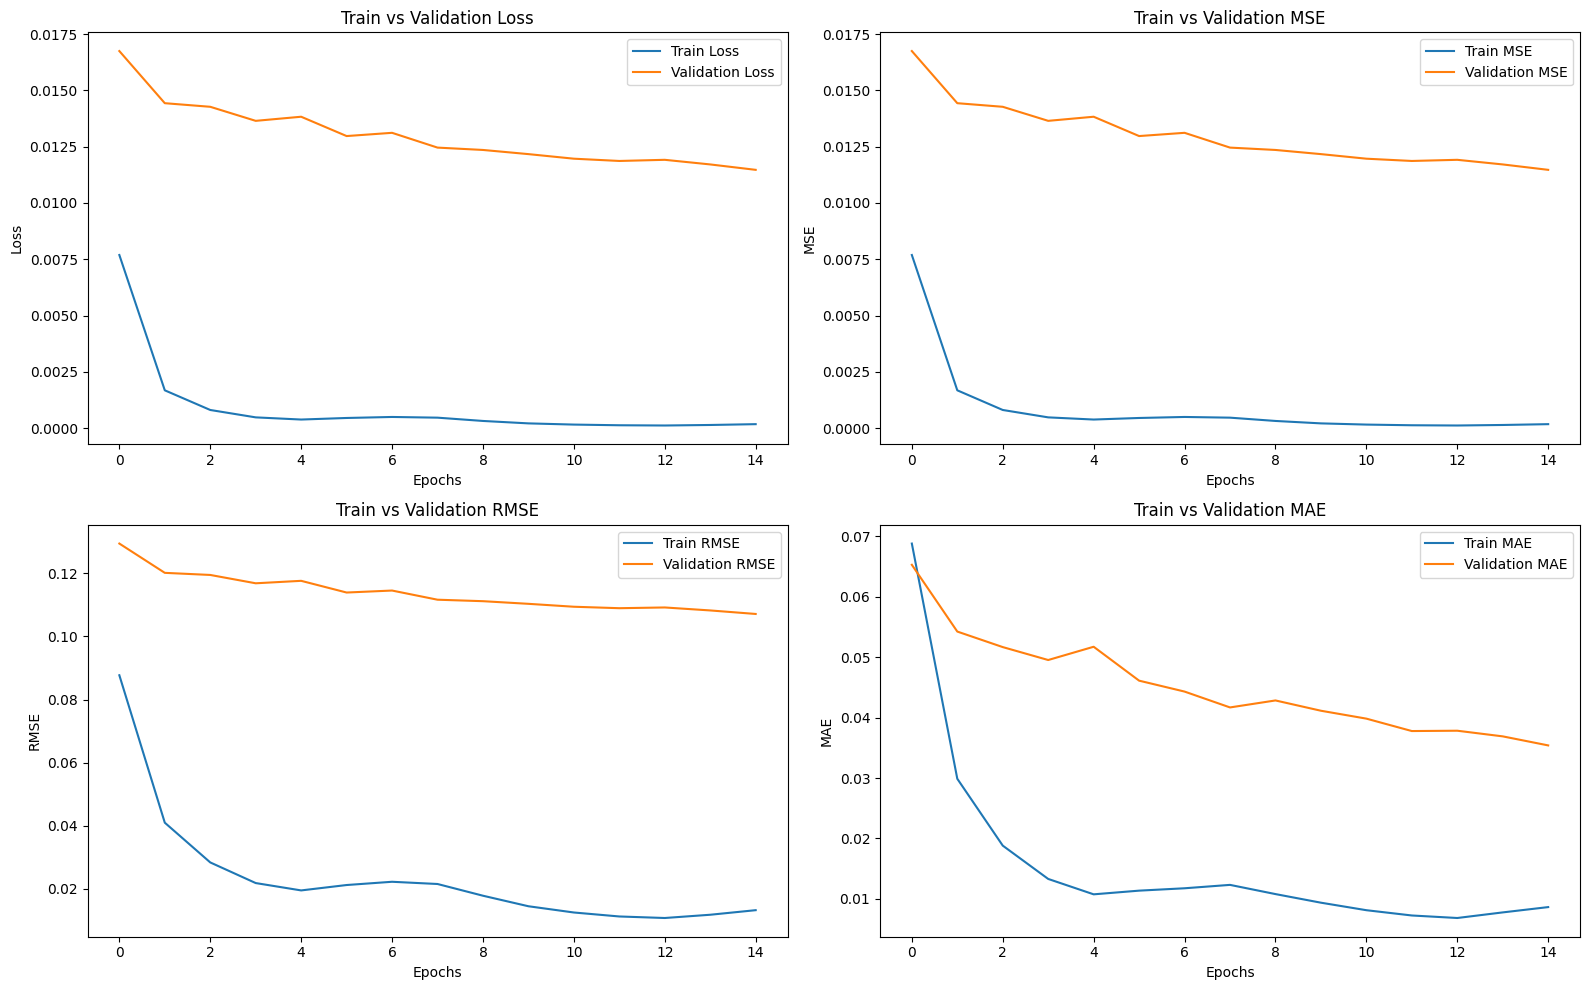

In [17]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

What is more unusual, is that after doing fine-tuning unfreezing layers from the model, the results got **worse**, although it seems that with a bit more epochs they could stabilize around 0.010, whioch is the barreir that we are facing right now.

## 3D CNN

After not being able to improve our results from the CNN of 0.01 in validation loss, we have 2 theories about why this might happening:
- Because the image although the most important part of a tiktok is sucha  "difuse" ìece of data and the virality of a tiktok is determined by so many factors and is influentied by so many things (including probably luck)
- Because with only 8 frames per video this is the maximum we can get

So we will evaluate a 3 dimensional CNN (width, height and time) and if results are the same will try to have more frames to use.

In [4]:
import torch
import torchvision
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo preentrenado
model = torchvision.models.video.r3d_18(pretrained=True)


# Cambiar la capa final para que tenga 1 salida en lugar de las salidas de clasificación
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

# Definir el criterio de pérdida y el optimizador
criterion = nn.MSELoss()  # Usar Mean Squared Error Loss para regresión
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model = model.to(device)

c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
X = np.transpose(X, (0, 4, 1, 2, 3))

In [7]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.20, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.50, random_state=42)
print("Train set:", len(X_train))
print("Validation set:", len(X_valid))
print("Test set:", len(X_test))

Train set: 800
Validation set: 100
Test set: 100


In [5]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class CNN3DDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (numpy array): Arreglo de imágenes con dimensiones [n_muestras, n_imágenes, H, W, C].
            labels (numpy array): Arreglo de etiquetas.
            transform (callable, optional): Transformaciones opcionales para aplicar a las imágenes.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_set = self.images[idx]
        label = self.labels[idx]
        
        transformed_images = []
        for image in image_set:
            img = Image.fromarray(image.astype('uint8'), 'RGB')  # Convertir NumPy array a PIL Image
            if self.transform:
                img = self.transform(img)
            transformed_images.append(img)

        # Stack the images along a new dimension
        image_set = torch.stack(transformed_images, dim=0)

        return {'image': image_set, 'label': torch.tensor(label, dtype=torch.float)}

# Definir transformaciones (normalización, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona las imágenes
    transforms.ToTensor(),          # Convierte las imágenes a Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = CNN3DDataset(X_train, y_train, transform=transform)
valid_dataset = CNN3DDataset(X_valid, y_valid, transform=transform)
test_dataset = CNN3DDataset(X_test, y_test, transform=transform)

In [11]:
batch_size = 4  # Puedes ajustar esto según la capacidad de tu GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
next(model.parameters()).device

device(type='cuda', index=0)

In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train_and_metrics(model, data_loader, optimizer, device, mse, rmse, mae):
    model.train()
    total_loss, total_mse, total_rmse, total_mae, count = 0, 0, 0, 0, 0
    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    for data in progress_bar:
        inputs = data['image'].to(device)
        labels = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()
        loss = F.mse_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # Actualización de la barra de progreso con información de la pérdida
        progress_bar.set_postfix({'loss': loss.item()})

        total_loss += loss.item() * inputs.size(0)
        total_mse += mse(outputs, labels).item() * inputs.size(0)
        total_rmse += rmse(outputs, labels).item() * inputs.size(0)
        total_mae += mae(outputs, labels).item() * inputs.size(0)
        count += inputs.size(0)
    
    return total_loss / count, total_mse / count, total_rmse / count, total_mae / count

def validate(model, data_loader, device, mse, rmse, mae):
    model.eval()
    total_loss, total_mse, total_rmse, total_mae, count = 0, 0, 0, 0, 0
    progress_bar = tqdm(data_loader, desc='Validation', leave=False)
    with torch.no_grad():
        for data in progress_bar:
            inputs = data['image'].to(device)
            labels = data['label'].to(device)

            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = F.mse_loss(outputs, labels)

            # Actualización de la barra de progreso
            progress_bar.set_postfix({'val_loss': loss.item()})

            total_loss += loss.item() * inputs.size(0)
            total_mse += mse(outputs, labels).item() * inputs.size(0)
            total_rmse += rmse(outputs, labels).item() * inputs.size(0)
            total_mae += mae(outputs, labels).item() * inputs.size(0)
            count += inputs.size(0)
    
    return total_loss / count, total_mse / count, total_rmse / count, total_mae / count

def rmse(outputs, labels):
    return torch.sqrt(F.mse_loss(outputs, labels))

def mae(outputs, labels):
    return F.l1_loss(outputs, labels)

In [7]:
import torchmetrics

# Métricas
mse_metric = torchmetrics.MeanSquaredError().to(device)
rmse_metric = torchmetrics.MeanSquaredError(squared=False).to(device)
mae_metric = torchmetrics.MeanAbsoluteError().to(device)

In [34]:
from tqdm import trange

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(model, valid_loader, device, mse_metric, rmse_metric, mae_metric)

    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Opcional: imprimir o guardar las métricas después de cada época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")


Epoch 1/10


Epoch 1, Train Loss: 0.0016, Train MSE: 0.0016, Train RMSE: 0.0256, Train MAE: 0.0213
Validation Loss: 0.0099, Validation MSE: 0.0099, Validation RMSE: 0.0344, Validation MAE: 0.0229
Epoch 2/10


Epoch 2, Train Loss: 0.0012, Train MSE: 0.0012, Train RMSE: 0.0200, Train MAE: 0.0161
Validation Loss: 0.0098, Validation MSE: 0.0098, Validation RMSE: 0.0290, Validation MAE: 0.0179
Epoch 3/10


Epoch 3, Train Loss: 0.0007, Train MSE: 0.0007, Train RMSE: 0.0163, Train MAE: 0.0131
Validation Loss: 0.0115, Validation MSE: 0.0115, Validation RMSE: 0.0495, Validation MAE: 0.0391
Epoch 4/10


Epoch 4, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0146, Train MAE: 0.0116
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0323, Validation MAE: 0.0216
Epoch 5/10


Epoch 5, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0128, Train MAE: 0.0101
Validation Loss: 0.0098, Validation MSE: 0.0098, Validation RMSE: 0.0312, Validation MAE: 0.0206
Epoch 6/10


Epoch 6, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0121, Train MAE: 0.0095
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0274, Validation MAE: 0.0165
Epoch 7/10


Epoch 7, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0122, Train MAE: 0.0096
Validation Loss: 0.0099, Validation MSE: 0.0099, Validation RMSE: 0.0265, Validation MAE: 0.0157
Epoch 8/10


Epoch 8, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0122, Train MAE: 0.0097
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0260, Validation MAE: 0.0151
Epoch 9/10


Epoch 9, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0114, Train MAE: 0.0091
Validation Loss: 0.0099, Validation MSE: 0.0099, Validation RMSE: 0.0361, Validation MAE: 0.0258
Epoch 10/10


Epoch 10, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0144, Train MAE: 0.0119
Validation Loss: 0.0107, Validation MSE: 0.0107, Validation RMSE: 0.0375, Validation MAE: 0.0266


Unsurprisingly, the results from the 3D CNN are still the same that we got from the regular CNN, getting a minimum of validation loss of 0.098

In [36]:
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

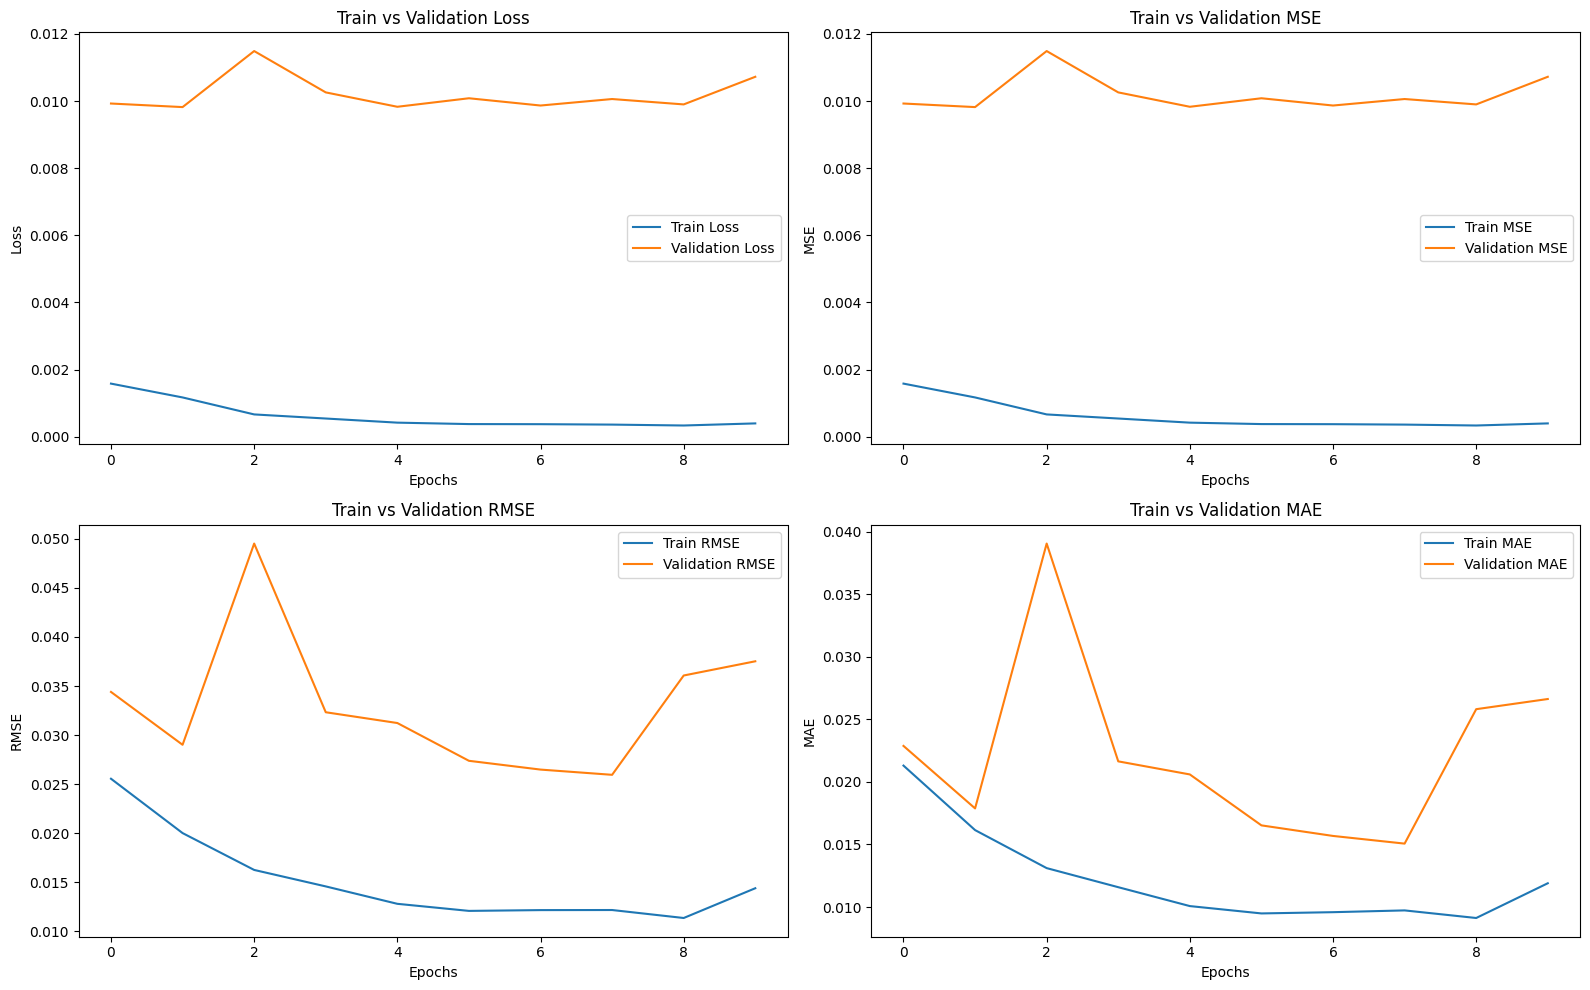

In [37]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

As we can see with a little test of 10 apochs we seem to be hitting that same 0.01 validation loss barrier that we encountered with both the standard CNN and the Pretrained transformer. We'll try to unfreeze some layers from this model to see if results gets worse the same way they did with the ViT

### Unfreezing layers

First we will unfreeze some layers, and if the results are not what we expected, we will change some hyperparameters to see if we can improve even the slightest bit

In [38]:
print(model)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [39]:
for name, param in model.named_parameters():
    # Específicamente seleccionando el último bloque de cada capa y toda la capa 'layer4'
    if 'layer1.1' in name or 'layer2.1' in name or 'layer3.1' in name or 'layer4' in name:
        param.requires_grad = True
        print(f"{name} has been unfrozen.")
    else:
        param.requires_grad = False
        print(f"{name} remains frozen.")

stem.0.weight remains frozen.
stem.1.weight remains frozen.
stem.1.bias remains frozen.
layer1.0.conv1.0.weight remains frozen.
layer1.0.conv1.1.weight remains frozen.
layer1.0.conv1.1.bias remains frozen.
layer1.0.conv2.0.weight remains frozen.
layer1.0.conv2.1.weight remains frozen.
layer1.0.conv2.1.bias remains frozen.
layer1.1.conv1.0.weight has been unfrozen.
layer1.1.conv1.1.weight has been unfrozen.
layer1.1.conv1.1.bias has been unfrozen.
layer1.1.conv2.0.weight has been unfrozen.
layer1.1.conv2.1.weight has been unfrozen.
layer1.1.conv2.1.bias has been unfrozen.
layer2.0.conv1.0.weight remains frozen.
layer2.0.conv1.1.weight remains frozen.
layer2.0.conv1.1.bias remains frozen.
layer2.0.conv2.0.weight remains frozen.
layer2.0.conv2.1.weight remains frozen.
layer2.0.conv2.1.bias remains frozen.
layer2.0.downsample.0.weight remains frozen.
layer2.0.downsample.1.weight remains frozen.
layer2.0.downsample.1.bias remains frozen.
layer2.1.conv1.0.weight has been unfrozen.
layer2.1.c

In [40]:
from tqdm import trange

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(model, valid_loader, device, mse_metric, rmse_metric, mae_metric)

    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Opcional: imprimir o guardar las métricas después de cada época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")

Epoch 1/10


Epoch 1, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0138, Train MAE: 0.0114
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0267, Validation MAE: 0.0159
Epoch 2/10


Epoch 2, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0129, Train MAE: 0.0106
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0369, Validation MAE: 0.0255
Epoch 3/10


Epoch 3, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0125, Train MAE: 0.0102
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0326, Validation MAE: 0.0216
Epoch 4/10


Epoch 4, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0122, Train MAE: 0.0098
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0284, Validation MAE: 0.0173
Epoch 5/10


Epoch 5, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0119, Train MAE: 0.0096
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0274, Validation MAE: 0.0166
Epoch 6/10


Epoch 6, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0132, Train MAE: 0.0109
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0386, Validation MAE: 0.0281
Epoch 7/10


Epoch 7, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0121, Train MAE: 0.0099
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0280, Validation MAE: 0.0168
Epoch 8/10


Epoch 8, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0120, Train MAE: 0.0097
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0304, Validation MAE: 0.0185
Epoch 9/10


Epoch 9, Train Loss: 0.0002, Train MSE: 0.0002, Train RMSE: 0.0118, Train MAE: 0.0099
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0270, Validation MAE: 0.0161
Epoch 10/10


Epoch 10, Train Loss: 0.0002, Train MSE: 0.0002, Train RMSE: 0.0111, Train MAE: 0.0092
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0337, Validation MAE: 0.0230


In [42]:
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

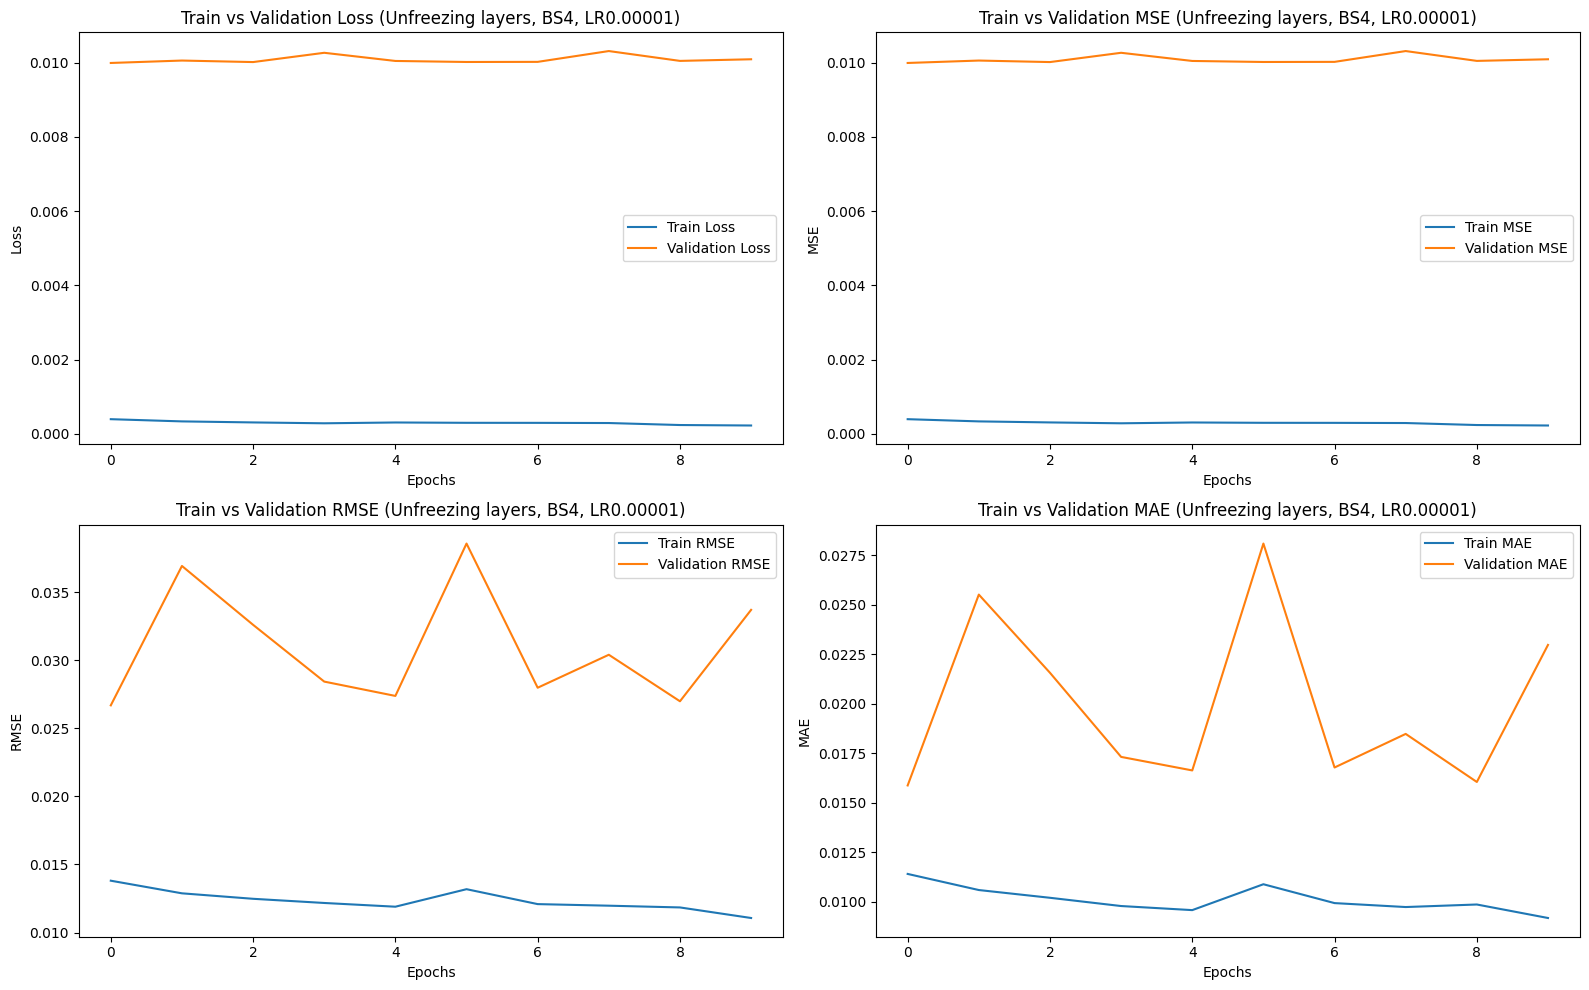

In [43]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss (Unfreezing layers, BS4, LR0.00001)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE (Unfreezing layers, BS4, LR0.00001)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE (Unfreezing layers, BS4, LR0.00001)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE (Unfreezing layers, BS4, LR0.00001)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

Different to the trasnformer, the 3d CNN does **NOT** loose performance when unfreezing layers, but it also won't improve it. We'll change the batch size to 8 (as the GPU can take it with this network) and the learning rate to 0.0001

In [45]:
batch_size = 8 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model = model.to(device)

In [46]:
from tqdm import trange

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(model, valid_loader, device, mse_metric, rmse_metric, mae_metric)

    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Opcional: imprimir o guardar las métricas después de cada época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")

Epoch 1/10


Training:   0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\torch\nn\modules\conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv3d(


Epoch 1, Train Loss: 0.0015, Train MSE: 0.0015, Train RMSE: 0.0256, Train MAE: 0.0211
Validation Loss: 0.0106, Validation MSE: 0.0106, Validation RMSE: 0.0421, Validation MAE: 0.0234
Epoch 2/10


Epoch 2, Train Loss: 0.0007, Train MSE: 0.0007, Train RMSE: 0.0191, Train MAE: 0.0149
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0440, Validation MAE: 0.0264
Epoch 3/10


Epoch 3, Train Loss: 0.0006, Train MSE: 0.0006, Train RMSE: 0.0176, Train MAE: 0.0143
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0367, Validation MAE: 0.0178
Epoch 4/10


Epoch 4, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0153, Train MAE: 0.0117
Validation Loss: 0.0102, Validation MSE: 0.0102, Validation RMSE: 0.0374, Validation MAE: 0.0190
Epoch 5/10


Epoch 5, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0160, Train MAE: 0.0124
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0330, Validation MAE: 0.0139
Epoch 6/10


Epoch 6, Train Loss: 0.0005, Train MSE: 0.0005, Train RMSE: 0.0162, Train MAE: 0.0130
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0341, Validation MAE: 0.0143
Epoch 7/10


Epoch 7, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0146, Train MAE: 0.0111
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0422, Validation MAE: 0.0218
Epoch 8/10


Epoch 8, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0151, Train MAE: 0.0118
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0332, Validation MAE: 0.0139
Epoch 9/10


Epoch 9, Train Loss: 0.0004, Train MSE: 0.0004, Train RMSE: 0.0141, Train MAE: 0.0106
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0354, Validation MAE: 0.0160
Epoch 10/10


Epoch 10, Train Loss: 0.0003, Train MSE: 0.0003, Train RMSE: 0.0140, Train MAE: 0.0108
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0439, Validation MAE: 0.0252


In [49]:
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

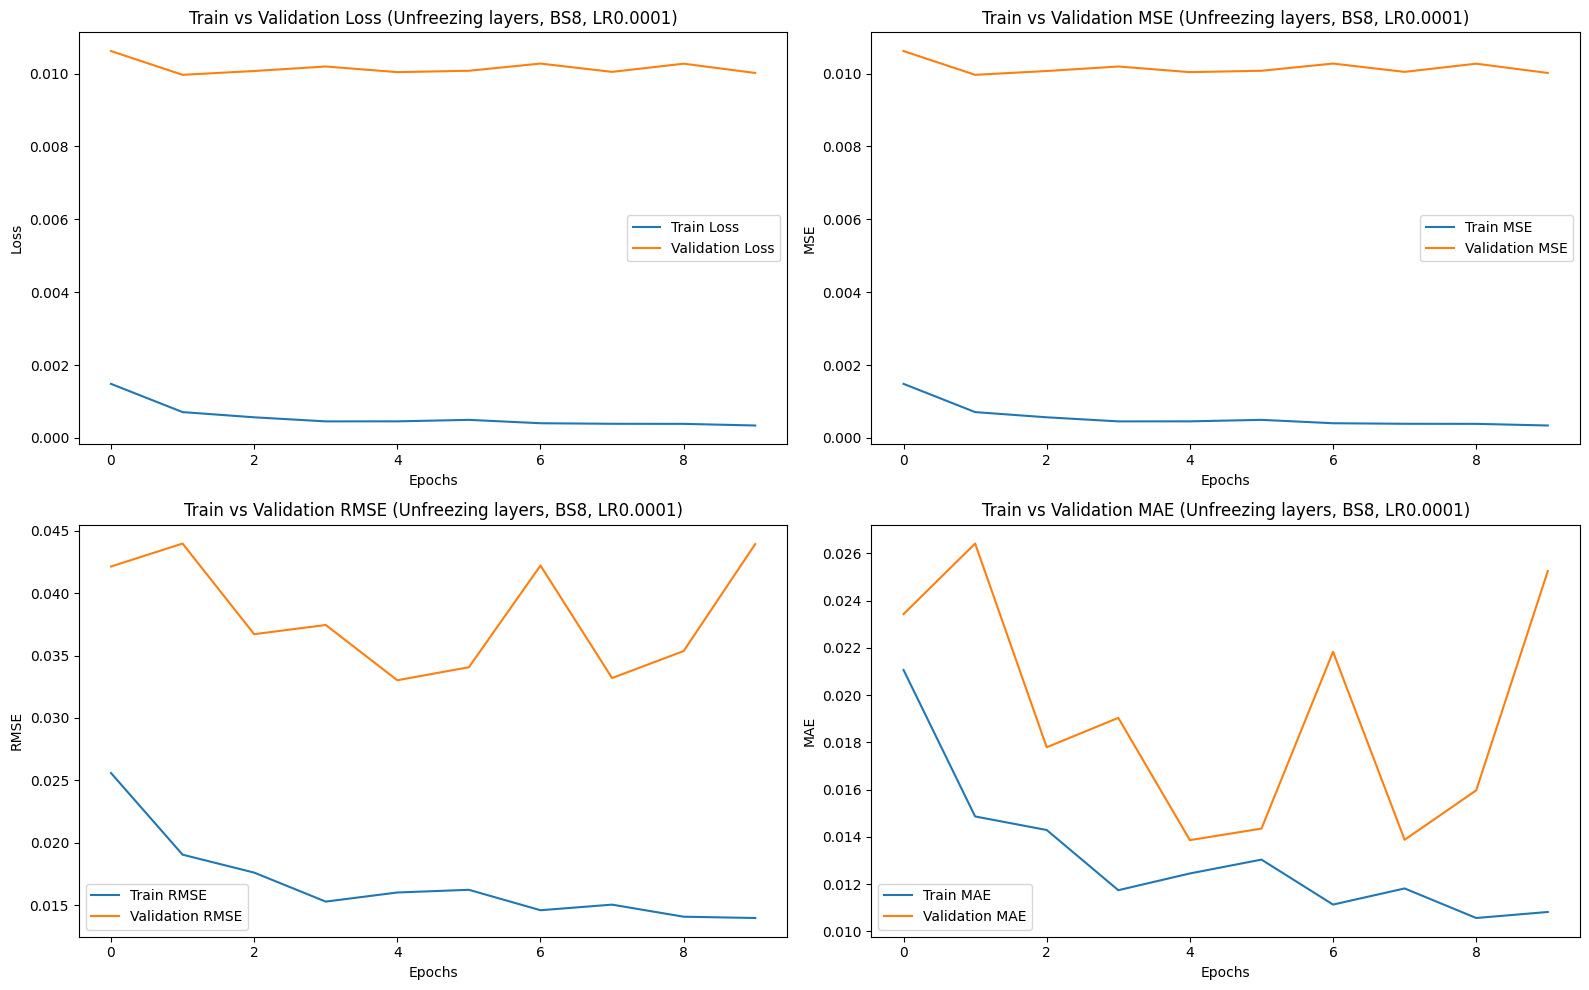

In [50]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss (Unfreezing layers, BS8, LR0.0001)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE (Unfreezing layers, BS8, LR0.0001)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE (Unfreezing layers, BS8, LR0.0001)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE (Unfreezing layers, BS8, LR0.0001)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

As it can be seen, no real improvments here, so the onlyb thing left to do is take more frames from each video to see if that 0.01 validation loss barrier can be broken with more information. We will try with 16 frames per video

### Frame extraction (again, this time 16 per tiktok)

In [3]:
extract_frames(16)

Saved: ../../data/inputs/frames\6875317312082201857_frame_0.png | Frame ID: 0
Saved: ../../data/inputs/frames\6875317312082201857_frame_1.png | Frame ID: 14
Saved: ../../data/inputs/frames\6875317312082201857_frame_2.png | Frame ID: 28
Saved: ../../data/inputs/frames\6875317312082201857_frame_3.png | Frame ID: 43
Saved: ../../data/inputs/frames\6875317312082201857_frame_4.png | Frame ID: 57
Saved: ../../data/inputs/frames\6875317312082201857_frame_5.png | Frame ID: 71
Saved: ../../data/inputs/frames\6875317312082201857_frame_6.png | Frame ID: 85
Saved: ../../data/inputs/frames\6875317312082201857_frame_7.png | Frame ID: 99
Saved: ../../data/inputs/frames\6875317312082201857_frame_8.png | Frame ID: 114
Saved: ../../data/inputs/frames\6875317312082201857_frame_9.png | Frame ID: 128
Saved: ../../data/inputs/frames\6875317312082201857_frame_10.png | Frame ID: 142
Saved: ../../data/inputs/frames\6875317312082201857_frame_11.png | Frame ID: 156
Saved: ../../data/inputs/frames\687531731208220

In [8]:
X, y = load_images(num_frames=16, img_height=112, img_width=112)


6907228749016714497


6875468410612993286
6898699405898059010
6902819837345533186
6905635666588192002
6895497835681287426
6895303013867539713
6884590643327290625
6906514963569888513
6894206452450217217
6902751117805899009
6886417103046380801
6883211681988627714
6892769736589888770
6906571896683285761
6907334602017344774
6883094233935252737
6906818204966915330
6876318382703070465
6900948690186407170
6875323773755657474
6884935459110178049
6892805816492084481
6886765050355289346
6875370613523909890
6890189236130073857
6901321371113032962
6893611785295793410
6904536120755768578
6888873392234056962
6879952519586450690
6884933059758755073
6895846066961337601
6884933447480003842
6883604590525156609
6886215675350666497
6899411430660001026
6898613799402753281
6885861410329332998
6879772200065436929
6893119957534510338
6881624031561354498
6896541657471241474
6884688821976354049
6906870391466216709
6901020148426099969
6898035916682710274
6901681280128208130
6887645369895898369
6905029441760578818
6879842043880017154


In [9]:
X = np.transpose(X, (0, 4, 1, 2, 3))

In [10]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.20, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.50, random_state=42)
print("Train set:", len(X_train))
print("Validation set:", len(X_valid))
print("Test set:", len(X_test))

Train set: 800
Validation set: 100
Test set: 100


In [11]:
X.shape

(1000, 3, 16, 112, 112)

In [12]:
train_dataset = CNN3DDataset(X_train, y_train, transform=transform)
valid_dataset = CNN3DDataset(X_valid, y_valid, transform=transform)
test_dataset = CNN3DDataset(X_test, y_test, transform=transform)

In [13]:
batch_size = 4  # Puedes ajustar esto según la capacidad de tu GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
from tqdm import trange

train_losses, valid_losses = [], []
train_mses, train_rmses, train_maes = [], [], []
valid_mses, valid_rmses, valid_maes = [], [], []

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_mse, train_rmse, train_mae = train_and_metrics(model, train_loader, optimizer, device, mse_metric, rmse_metric, mae_metric)
    valid_loss, valid_mse, valid_rmse, valid_mae = validate(model, valid_loader, device, mse_metric, rmse_metric, mae_metric)

    train_losses.append(train_loss)
    train_mses.append(train_mse)
    train_rmses.append(train_rmse)
    train_maes.append(train_mae)
    valid_losses.append(valid_loss)
    valid_mses.append(valid_mse)
    valid_rmses.append(valid_rmse)
    valid_maes.append(valid_mae)

    # Opcional: imprimir o guardar las métricas después de cada época
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation MSE: {valid_mse:.4f}, Validation RMSE: {valid_rmse:.4f}, Validation MAE: {valid_mae:.4f}")


Epoch 1/10


Training:   0%|          | 0/200 [00:00<?, ?it/s]c:\Users\ignac\Desktop\ICAI\TikTok-sentiment-analysis\tiktok\Lib\site-packages\torch\nn\modules\conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv3d(


Epoch 1, Train Loss: 0.0535, Train MSE: 0.0535, Train RMSE: 0.1903, Train MAE: 0.1895
Validation Loss: 0.0140, Validation MSE: 0.0140, Validation RMSE: 0.0890, Validation MAE: 0.0816
Epoch 2/10


Epoch 2, Train Loss: 0.0034, Train MSE: 0.0034, Train RMSE: 0.0578, Train MAE: 0.0572
Validation Loss: 0.0113, Validation MSE: 0.0113, Validation RMSE: 0.0644, Validation MAE: 0.0561
Epoch 3/10


Epoch 3, Train Loss: 0.0020, Train MSE: 0.0020, Train RMSE: 0.0434, Train MAE: 0.0426
Validation Loss: 0.0106, Validation MSE: 0.0106, Validation RMSE: 0.0546, Validation MAE: 0.0459
Epoch 4/10


Epoch 4, Train Loss: 0.0014, Train MSE: 0.0014, Train RMSE: 0.0365, Train MAE: 0.0357
Validation Loss: 0.0104, Validation MSE: 0.0104, Validation RMSE: 0.0502, Validation MAE: 0.0413
Epoch 5/10


Epoch 5, Train Loss: 0.0012, Train MSE: 0.0012, Train RMSE: 0.0322, Train MAE: 0.0312
Validation Loss: 0.0103, Validation MSE: 0.0103, Validation RMSE: 0.0484, Validation MAE: 0.0395
Epoch 6/10


Epoch 6, Train Loss: 0.0010, Train MSE: 0.0010, Train RMSE: 0.0291, Train MAE: 0.0281
Validation Loss: 0.0101, Validation MSE: 0.0101, Validation RMSE: 0.0447, Validation MAE: 0.0355
Epoch 7/10


Epoch 7, Train Loss: 0.0009, Train MSE: 0.0009, Train RMSE: 0.0268, Train MAE: 0.0257
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0423, Validation MAE: 0.0330
Epoch 8/10


Epoch 8, Train Loss: 0.0008, Train MSE: 0.0008, Train RMSE: 0.0248, Train MAE: 0.0238
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0412, Validation MAE: 0.0319
Epoch 9/10


Epoch 9, Train Loss: 0.0007, Train MSE: 0.0007, Train RMSE: 0.0233, Train MAE: 0.0221
Validation Loss: 0.0100, Validation MSE: 0.0100, Validation RMSE: 0.0387, Validation MAE: 0.0293
Epoch 10/10


Epoch 10, Train Loss: 0.0006, Train MSE: 0.0006, Train RMSE: 0.0219, Train MAE: 0.0207
Validation Loss: 0.0099, Validation MSE: 0.0099, Validation RMSE: 0.0376, Validation MAE: 0.0282


In [15]:
metrics_df = pd.DataFrame({
    'Train Loss': train_losses,
    'Train MSE': train_mses,
    'Train RMSE': train_rmses,
    'Train MAE': train_maes,
    'Validation Loss': valid_losses,
    'Validation MSE': valid_mses,
    'Validation RMSE': valid_rmses,
    'Validation MAE': valid_maes
})

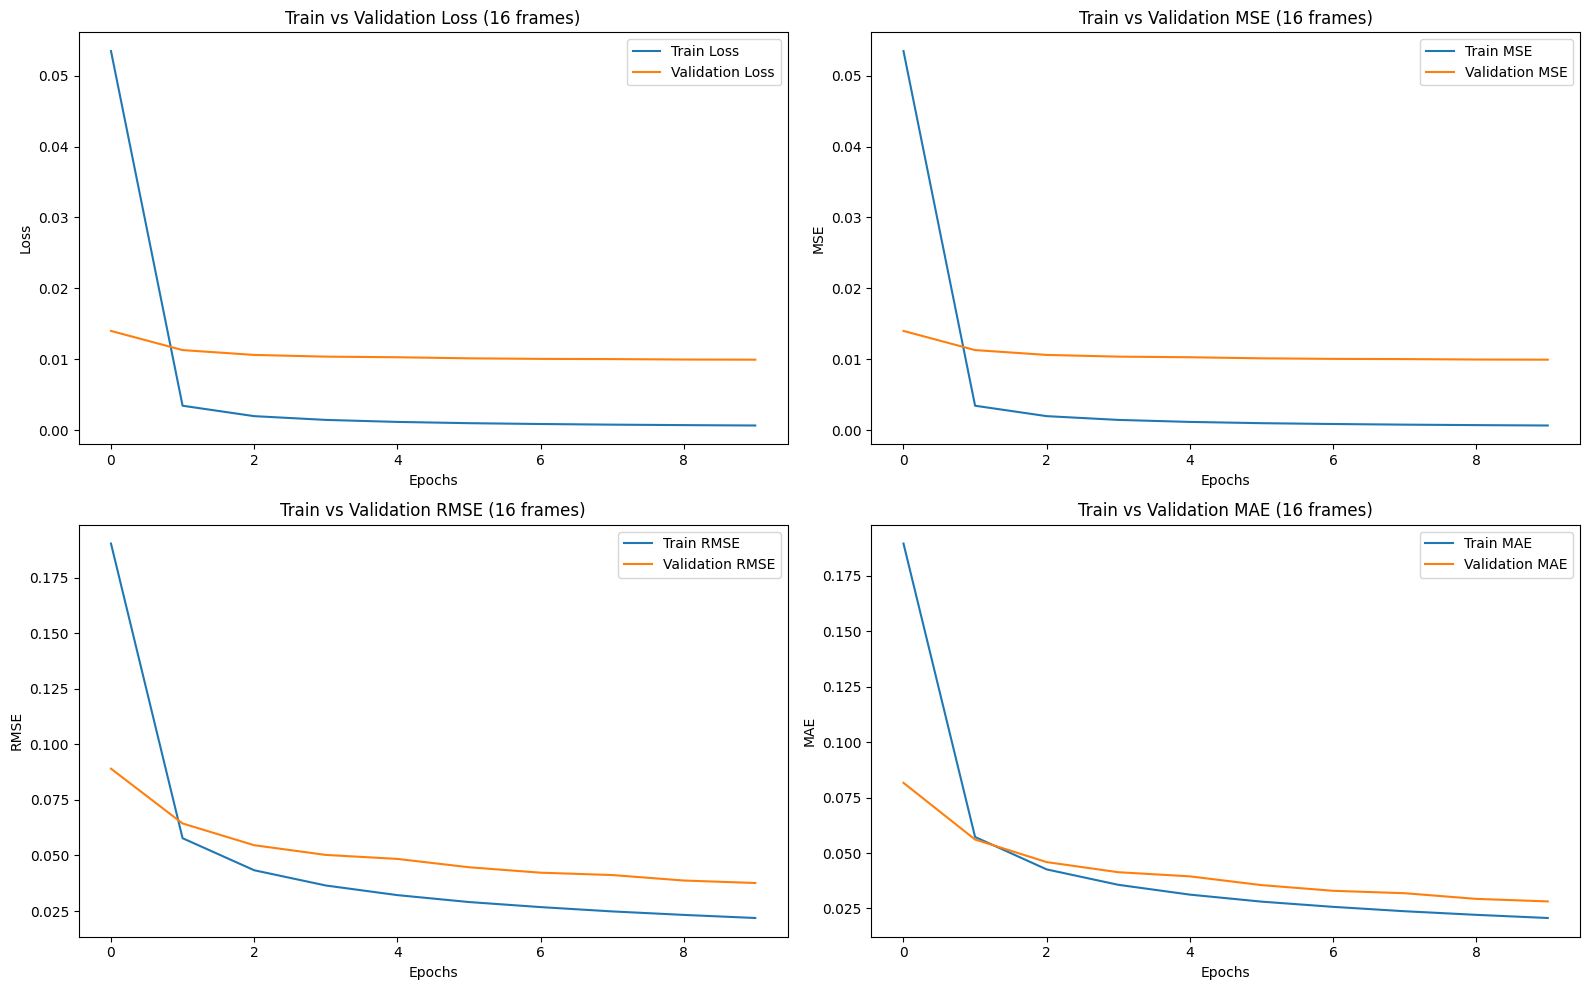

In [16]:
import matplotlib.pyplot as plt

# Configurar el tamaño de la figura
plt.figure(figsize=(16, 10))

# Gráfico para la pérdida de entrenamiento y validación
plt.subplot(2, 2, 1)
plt.plot(metrics_df['Train Loss'], label='Train Loss')
plt.plot(metrics_df['Validation Loss'], label='Validation Loss')
plt.title('Train vs Validation Loss (16 frames)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Gráfico para MSE de entrenamiento y validación
plt.subplot(2, 2, 2)
plt.plot(metrics_df['Train MSE'], label='Train MSE')
plt.plot(metrics_df['Validation MSE'], label='Validation MSE')
plt.title('Train vs Validation MSE (16 frames)')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Gráfico para RMSE de entrenamiento y validación
plt.subplot(2, 2, 3)
plt.plot(metrics_df['Train RMSE'], label='Train RMSE')
plt.plot(metrics_df['Validation RMSE'], label='Validation RMSE')
plt.title('Train vs Validation RMSE (16 frames)')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# Gráfico para MAE de entrenamiento y validación
plt.subplot(2, 2, 4)
plt.plot(metrics_df['Train MAE'], label='Train MAE')
plt.plot(metrics_df['Validation MAE'], label='Validation MAE')
plt.title('Train vs Validation MAE (16 frames)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()

Finally, with 16 frames, the result  is still pretty much the same as with the standard CNN, the pretrained transformer (without fine tuning and better than with fine tuning) and the 3D CNN with 8 frames per video.

# CONCLUSSIONS

We've tested various models including the CNN, a pretrained transformer, and three-dimensional CNNs with both 8 and 16 frames, only to find that all models are overfitting and struggling to lower their validation loss beyond 0.01. Considering these results, we've decided to stick with the three-dimensional CNN that uses 16 frames. We believe that with more computing power, this model could potentially achieve better results. Our choice is based on the potential that with additional computational resources, we might overcome the current performance plateau and improve how the model handles our data.

We’re choosing the 16-frame three-dimensional CNN because we believe it offers the best chance of improvement with more powerful hardware. 

In [17]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'ImageModel2.pth')